## This code get the GBPUSD weekly data, then clean data and build model to evaluation next week trend. Then save it and create a CSV file as an input to MQL expert that i have wrote before. 
### I cut data start from 2000,1,1 till 2025,1,1

In [1]:
# Importing Libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
import random
import talib as ta

In [12]:
# Importing dataset
#dataset = pd.read_csv('D:/AmirAgah/New_Methods_Courses/Data/GBPUSD_DailyData.csv')
dataset = pd.read_csv('D:/AmirAgah/New_Methods_Courses/Data/AUDUSD_WeeklyData.csv')

In [13]:
len(dataset)

7001

In [14]:
dataset.iloc[5689]

Date      2000.08.06 00:00:00
Open                   0.5865
High                   0.5892
Low                    0.5765
Close                   0.579
Volume                  16607
Name: 5689, dtype: object

In [15]:
dataset['Open'].shift(1).head()

0    NaN
1    0.0
2    0.0
3    0.0
4    0.0
Name: Open, dtype: float64

In [16]:
dataset = dataset.iloc[5689:]

In [17]:
len(dataset)

1312

In [18]:
dataset.head()

,Date,Open,High,Low,Close,Volume
5689,2000.08.06 00:00:00,0.5865,0.5892,0.5765,0.5790,16607
5690,2000.08.13 00:00:00,0.5792,0.5948,0.5770,0.5905,18459
5691,2000.08.20 00:00:00,0.5909,0.5915,0.5667,0.5738,18890
5692,2000.08.27 00:00:00,0.5733,0.5794,0.5682,0.5762,16630
5693,2000.09.03 00:00:00,0.5765,0.5785,0.5526,0.5552,20104


In [19]:
dataset.tail()

,Date,Open,High,Low,Close,Volume
6996,2025.08.24 00:00:00,0.64865,0.65479,0.64617,0.65343,199559
6997,2025.08.31 00:00:00,0.65438,0.65884,0.64825,0.65518,197274
6998,2025.09.07 00:00:00,0.65497,0.66685,0.65453,0.66460,155556
6999,2025.11.16 00:00:00,0.64483,0.64609,0.64214,0.64538,40909
7000,2025.11.23 00:00:00,0.64543,0.64675,0.64422,0.64624,29308


In [20]:
# Drop the rows with zero volume traded
dataset = dataset.drop(dataset[dataset['Volume'] == 0].index)

# Convert the 'Time' column into pandas datetime format
dataset['Date'] = pd.to_datetime(dataset['Date'])
# Set the Time column as index
#dataset.set_index('Date', inplace=True)

In [21]:
dataset.head()

,Date,Open,High,Low,Close,Volume
5689,2000-08-06,0.5865,0.5892,0.5765,0.5790,16607
5690,2000-08-13,0.5792,0.5948,0.5770,0.5905,18459
5691,2000-08-20,0.5909,0.5915,0.5667,0.5738,18890
5692,2000-08-27,0.5733,0.5794,0.5682,0.5762,16630
5693,2000-09-03,0.5765,0.5785,0.5526,0.5552,20104


In [22]:
dataset.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

### Here few indicator will be added to our dataframe.

In [23]:
#Preparing the dataset
dataset['H-L'] = dataset['High'] - dataset['Low']
dataset['O-C'] = dataset['Close'] - dataset['Open']
dataset['3day MA'] = dataset['Close'].shift(1).rolling(window = 3).mean()
dataset['10day MA'] = dataset['Close'].shift(1).rolling(window = 10).mean()
dataset['30day MA'] = dataset['Close'].shift(1).rolling(window = 30).mean()
dataset['50day MA'] = dataset['Close'].shift(1).rolling(window = 50).mean()
dataset['Std_dev']= dataset['Close'].rolling(5).std()
# Create RSI and stochastic
dataset['RSI-9'] = ta.RSI(dataset['Close'].values, timeperiod = 9)
dataset['slowk'],dataset['slowd'] = ta.STOCH(high=dataset['High'].values, low=dataset['Low'].values, 
                                             close=dataset['Close'].values, fastk_period=5, slowk_period=3, 
                                             slowk_matype=0, slowd_period=3, slowd_matype=0)
#STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)

In [24]:
dataset.head()

,Date,Open,High,Low,Close,Volume,H-L,O-C,3day MA,10day MA,30day MA,50day MA,Std_dev,RSI-9,slowk,slowd
5689,2000-08-06,0.5865,0.5892,0.5765,0.5790,16607,0.0127,-0.0075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5690,2000-08-13,0.5792,0.5948,0.5770,0.5905,18459,0.0178,0.0113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5691,2000-08-20,0.5909,0.5915,0.5667,0.5738,18890,0.0248,-0.0171,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5692,2000-08-27,0.5733,0.5794,0.5682,0.5762,16630,0.0112,0.0029,0.581100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5693,2000-09-03,0.5765,0.5785,0.5526,0.5552,20104,0.0259,-0.0213,0.580167,NaN,NaN,NaN,0.012759,NaN,NaN,NaN


#### After we creating indicators now we have few NULL cells, we will drop them all.
#### here we create our target column, named "Price_Rise"

In [25]:
#--- 1 means RISE and 0 means down
dataset['Price_Rise'] = np.where(dataset['Close'].shift(1) > dataset['Open'].shift(1), 0, 1)

In [26]:
dataset[['Date','Close','Open','Price_Rise']].head()

,Date,Close,Open,Price_Rise
5689,2000-08-06,0.5790,0.5865,1
5690,2000-08-13,0.5905,0.5792,1
5691,2000-08-20,0.5738,0.5909,0
5692,2000-08-27,0.5762,0.5733,1
5693,2000-09-03,0.5552,0.5765,0


In [27]:
dataset.isnull().sum()

Date           0
Open           0
High           0
Low            0
Close          0
Volume         0
H-L            0
O-C            0
3day MA        3
10day MA      10
30day MA      30
50day MA      50
Std_dev        4
RSI-9          9
slowk          8
slowd          8
Price_Rise     0
dtype: int64

In [28]:
dataset = dataset.dropna()

In [29]:
len(dataset)

1262

<Axes: xlabel='Price_Rise', ylabel='count'>

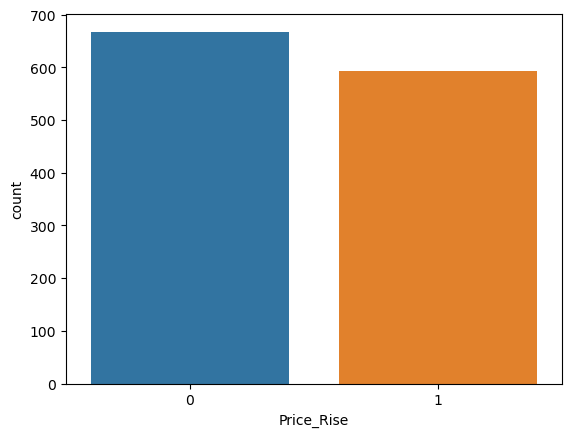

In [30]:
# Some data visualization
import seaborn as sns
sns.countplot(x='Price_Rise', data=dataset)

In [31]:
dataset.corr(numeric_only=True)['Price_Rise'].sort_values()

slowk        -0.411852
RSI-9        -0.351481
slowd        -0.240302
O-C          -0.024676
Low          -0.003149
Close        -0.002388
Open          0.000038
High          0.002573
Std_dev       0.044006
3day MA       0.048118
10day MA      0.067124
H-L           0.069947
30day MA      0.072619
50day MA      0.074028
Volume        0.090050
Price_Rise    1.000000
Name: Price_Rise, dtype: float64

#### Dataset for training and testing preparation 

In [32]:
# Split data
# X = dataset.drop(['Price_Rise'],axis=1).values
X = dataset.drop(['Date','Open','Close','High','Low','Price_Rise'],axis=1).values
y = dataset['Price_Rise'].values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [33]:
# Data scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [34]:
# Create model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

n_features = X_train.shape[1]
X_train.shape

(1009, 11)

In [35]:
# Shape in this array must be as input for model.
model = Sequential()

model.add(Dense(n_features, activation='gelu'))
#model.add(Dropout(0.2))
model.add(Dense(n_features, activation='gelu'))
#model.add(Dropout(0.2))
model.add(Dense(n_features, activation='gelu'))
#model.add(Dropout(0.2))
#model.add(Dense(n_features, activation='gelu'))
#model.add(Dropout(0.2))
#model.add(Dense(n_features, activation='gelu'))
#model.add(Dropout(0.2))
#model.add(Dense(n_features, activation='gelu'))
#model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

# For a binary classification problem
model.compile(loss='binary_crossentropy', optimizer='adam')

In [36]:
# Create call back
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=25)
model.fit(x=X_train, y=y_train, epochs=600, validation_data=(X_test, y_test), callbacks=[early_stop],validation_split=0.2)

Epoch 1/600
32/32 [==============================] - 2s 13ms/step - loss: 0.6984 - val_loss: 0.6939
Epoch 2/600
32/32 [==============================] - 0s 4ms/step - loss: 0.6899 - val_loss: 0.6884
Epoch 3/600
32/32 [==============================] - 0s 4ms/step - loss: 0.6822 - val_loss: 0.6827
Epoch 4/600
32/32 [==============================] - 0s 4ms/step - loss: 0.6725 - val_loss: 0.6745
Epoch 5/600
32/32 [==============================] - 0s 4ms/step - loss: 0.6592 - val_loss: 0.6645
Epoch 6/600
32/32 [==============================] - 0s 3ms/step - loss: 0.6463 - val_loss: 0.6584
Epoch 7/600
32/32 [==============================] - 0s 4ms/step - loss: 0.6403 - val_loss: 0.6561
Epoch 8/600
32/32 [==============================] - 0s 4ms/step - loss: 0.6345 - val_loss: 0.6536
Epoch 9/600
32/32 [==============================] - 0s 4ms/step - loss: 0.6320 - val_loss: 0.6525
Epoch 10/600
32/32 [==============================] - 0s 3ms/step - loss: 0.6315 - val_loss: 0.6495
Epoch 11

32/32 [==============================] - 0s 3ms/step - loss: 0.4755 - val_loss: 0.5201
Epoch 84/600
32/32 [==============================] - 0s 3ms/step - loss: 0.4756 - val_loss: 0.5233
Epoch 85/600
32/32 [==============================] - 0s 4ms/step - loss: 0.4850 - val_loss: 0.5203
Epoch 86/600
32/32 [==============================] - 0s 3ms/step - loss: 0.4715 - val_loss: 0.5198
Epoch 87/600
32/32 [==============================] - 0s 3ms/step - loss: 0.4784 - val_loss: 0.5400
Epoch 88/600
32/32 [==============================] - 0s 3ms/step - loss: 0.4792 - val_loss: 0.5340
Epoch 89/600
32/32 [==============================] - 0s 3ms/step - loss: 0.4769 - val_loss: 0.5211
Epoch 90/600
32/32 [==============================] - 0s 4ms/step - loss: 0.4741 - val_loss: 0.5195
Epoch 91/600
32/32 [==============================] - 0s 5ms/step - loss: 0.4748 - val_loss: 0.5183
Epoch 92/600
32/32 [==============================] - 0s 4ms/step - loss: 0.4771 - val_loss: 0.5215
Epoch 93/600


In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 11)                132       
                                                                 
 dense_1 (Dense)             (None, 11)                132       
                                                                 
 dense_2 (Dense)             (None, 11)                132       
                                                                 
 dense_3 (Dense)             (None, 1)                 12        
                                                                 
Total params: 408 (1.59 KB)
Trainable params: 408 (1.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


<Axes: >

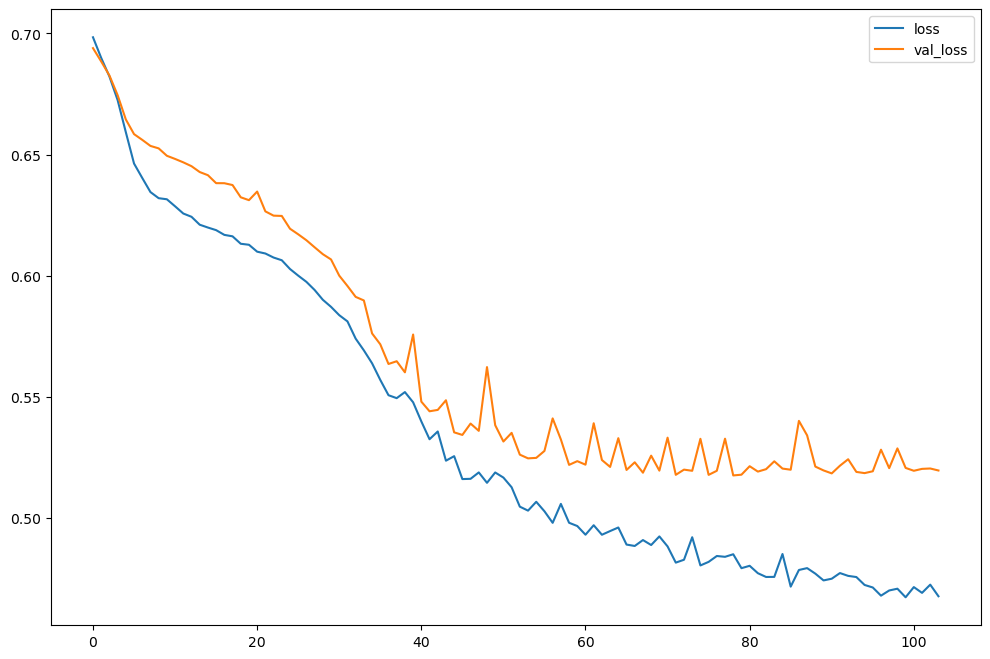

In [39]:
# See result
losses = pd.DataFrame(model.history.history)
losses.plot(figsize=(12,8))

In [40]:
# Predict
#predictions = model.predict_classes(X_test)
predictions = (model.predict(X_test) > 0.5).astype("int32")
#predictions = np.argmax(model.predict(X_test), axis=-1)
#predictions = model.predict(X_test)


from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))


8/8 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.76      0.79      0.78       131
           1       0.77      0.74      0.75       122

    accuracy                           0.77       253
   macro avg       0.77      0.77      0.77       253
weighted avg       0.77      0.77      0.77       253

[[104  27]
 [ 32  90]]


In [41]:
y_test.shape

(253,)

In [42]:
y_hat = y_test.reshape(-1,1)

In [43]:
d = np.array([predictions[:,0],y_test])

In [44]:
res_pd = pd.DataFrame(d).transpose().tail(20)
res_pd.columns=['pred','real']
res_pd

,pred,real
233,0,0
234,1,1
235,1,1
236,1,0
237,1,1
238,0,1
239,1,1
240,0,0
241,0,0
242,1,1


In [46]:
# Save model
from keras.models import load_model

model.save('D:/AmirAgah/Model_Saved/ANN_AUSUSD_Weekly.hdf5')
#model.save('D:/AmirAgah/Project/Final_Prediction_models/ANN_CLASSIFICATION_KERAS/ANN_AUSUSD_Daily_Classification.h5')
#model.save('ANN_AUDUSD_DAILY.h5')

#### Predict for all Data. 
Here we predict all the data that we have with the saved model, then we drop all columns and create a new data frame 
that includes From_Date, To_Date and Riseing Predictions. Then we save it as a CSV file and send it to MQL.

In [47]:
dataset.head()

,Date,Open,High,Low,Close,Volume,H-L,O-C,3day MA,10day MA,30day MA,50day MA,Std_dev,RSI-9,slowk,slowd,Price_Rise
5739,2001-07-22,0.5061,0.5119,0.5042,0.5084,17026,0.0077,0.0023,0.507567,0.51586,0.522570,0.531452,0.001809,43.444972,25.176494,22.691304,1
5740,2001-07-29,0.5083,0.5212,0.5018,0.5167,21590,0.0194,0.0084,0.507367,0.51369,0.520893,0.530040,0.004182,51.779012,43.120489,29.412206,0
5741,2001-08-05,0.5163,0.5202,0.5091,0.5128,20478,0.0111,-0.0035,0.510267,0.51332,0.519077,0.528564,0.004395,48.037047,56.746665,41.681216,0
5742,2001-08-12,0.5136,0.5375,0.5132,0.5357,24606,0.0243,0.0221,0.512633,0.51375,0.517620,0.527344,0.011859,64.827766,77.032199,58.966451,1
5743,2001-08-19,0.5364,0.5394,0.5287,0.5344,21555,0.0107,-0.0020,0.521733,0.51472,0.516937,0.526534,0.012633,63.516998,80.025317,71.268061,0


In [48]:
new_dataset = dataset
new_dataset.reset_index(drop=True,inplace=True)
new_dataset

,Date,Open,High,Low,Close,Volume,H-L,O-C,3day MA,10day MA,30day MA,50day MA,Std_dev,RSI-9,slowk,slowd,Price_Rise
0,2001-07-22,0.50610,0.51190,0.50420,0.50840,17026,0.00770,0.00230,0.507567,0.515860,0.522570,0.531452,0.001809,43.444972,25.176494,22.691304,1
1,2001-07-29,0.50830,0.52120,0.50180,0.51670,21590,0.01940,0.00840,0.507367,0.513690,0.520893,0.530040,0.004182,51.779012,43.120489,29.412206,0
2,2001-08-05,0.51630,0.52020,0.50910,0.51280,20478,0.01110,-0.00350,0.510267,0.513320,0.519077,0.528564,0.004395,48.037047,56.746665,41.681216,0
3,2001-08-12,0.51360,0.53750,0.51320,0.53570,24606,0.02430,0.02210,0.512633,0.513750,0.517620,0.527344,0.011859,64.827766,77.032199,58.966451,1
4,2001-08-19,0.53640,0.53940,0.52870,0.53440,21555,0.01070,-0.00200,0.521733,0.514720,0.516937,0.526534,0.012633,63.516998,80.025317,71.268061,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1257,2025-08-24,0.64865,0.65479,0.64617,0.65343,199559,0.00862,0.00478,0.650280,0.651343,0.639809,0.643751,0.002694,56.497102,49.937743,43.207133,1
1258,2025-08-31,0.65438,0.65884,0.64825,0.65518,197274,0.01059,0.00080,0.650853,0.652216,0.640890,0.643413,0.002532,58.279880,62.522101,51.535030,0
1259,2025-09-07,0.65497,0.66685,0.65453,0.66460,155556,0.01232,0.00963,0.652427,0.652424,0.641825,0.642906,0.006203,66.574898,80.833833,64.431226,0
1260,2025-11-16,0.64483,0.64609,0.64214,0.64538,40909,0.00395,0.00055,0.657737,0.653441,0.642818,0.642396,0.007336,45.712582,62.900757,68.752230,0


In [49]:
df_for_predict = new_dataset.drop(['Open','Close','High','Low','Price_Rise'],axis=1)

In [50]:
df_for_predict.head()

,Date,Volume,H-L,O-C,3day MA,10day MA,30day MA,50day MA,Std_dev,RSI-9,slowk,slowd
0,2001-07-22,17026,0.0077,0.0023,0.507567,0.51586,0.522570,0.531452,0.001809,43.444972,25.176494,22.691304
1,2001-07-29,21590,0.0194,0.0084,0.507367,0.51369,0.520893,0.530040,0.004182,51.779012,43.120489,29.412206
2,2001-08-05,20478,0.0111,-0.0035,0.510267,0.51332,0.519077,0.528564,0.004395,48.037047,56.746665,41.681216
3,2001-08-12,24606,0.0243,0.0221,0.512633,0.51375,0.517620,0.527344,0.011859,64.827766,77.032199,58.966451
4,2001-08-19,21555,0.0107,-0.0020,0.521733,0.51472,0.516937,0.526534,0.012633,63.516998,80.025317,71.268061


In [51]:
df_for_predict['Date'].iloc[72].day

8

In [52]:
#### Buikd To_Date column

In [53]:
df_for_predict['To_Date'] = df_for_predict['Date'].shift(-1)
df_for_predict = df_for_predict.dropna()

In [54]:
df_for_predict

,Date,Volume,H-L,O-C,3day MA,10day MA,30day MA,50day MA,Std_dev,RSI-9,slowk,slowd,To_Date
0,2001-07-22,17026,0.00770,0.00230,0.507567,0.515860,0.522570,0.531452,0.001809,43.444972,25.176494,22.691304,2001-07-29
1,2001-07-29,21590,0.01940,0.00840,0.507367,0.513690,0.520893,0.530040,0.004182,51.779012,43.120489,29.412206,2001-08-05
2,2001-08-05,20478,0.01110,-0.00350,0.510267,0.513320,0.519077,0.528564,0.004395,48.037047,56.746665,41.681216,2001-08-12
3,2001-08-12,24606,0.02430,0.02210,0.512633,0.513750,0.517620,0.527344,0.011859,64.827766,77.032199,58.966451,2001-08-19
4,2001-08-19,21555,0.01070,-0.00200,0.521733,0.514720,0.516937,0.526534,0.012633,63.516998,80.025317,71.268061,2001-08-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,2025-08-17,205335,0.01155,-0.00208,0.649547,0.651310,0.639224,0.644114,0.003750,51.484687,42.145245,42.897069,2025-08-24
1257,2025-08-24,199559,0.00862,0.00478,0.650280,0.651343,0.639809,0.643751,0.002694,56.497102,49.937743,43.207133,2025-08-31
1258,2025-08-31,197274,0.01059,0.00080,0.650853,0.652216,0.640890,0.643413,0.002532,58.279880,62.522101,51.535030,2025-09-07
1259,2025-09-07,155556,0.01232,0.00963,0.652427,0.652424,0.641825,0.642906,0.006203,66.574898,80.833833,64.431226,2025-11-16


In [55]:
df_for_predict.columns

Index(['Date', 'Volume', 'H-L', 'O-C', '3day MA', '10day MA', '30day MA',
       '50day MA', 'Std_dev', 'RSI-9', 'slowk', 'slowd', 'To_Date'],
      dtype='object')

In [56]:
# prepair data for predicting by model

X_for_prediction = df_for_predict.drop(['Date','To_Date'],axis=1).values
#y = dataset['Price_Rise'].values

In [57]:
X_for_prediction.shape

(1261, 11)

In [58]:
scaleld_X_for_prediction = scaler.transform(X_for_prediction)

In [59]:
scaleld_X_for_prediction

array([[0.00763086, 0.03791156, 0.72530522, ..., 0.43247432, 0.24287996,
        0.21045506],
       [0.01279888, 0.12370756, 0.75915649, ..., 0.53616741, 0.42902276,
        0.28154373],
       [0.01153972, 0.06284373, 0.69311876, ..., 0.48960945, 0.57037447,
        0.41131614],
       ...,
       [0.21173357, 0.05910391, 0.71698113, ..., 0.61705196, 0.6302862 ,
        0.51554241],
       [0.16449445, 0.07178998, 0.76598224, ..., 0.72025952, 0.82024373,
        0.65194873],
       [0.03467463, 0.01041285, 0.71559378, ..., 0.46068818, 0.6342142 ,
        0.69765308]])

In [61]:
#Model Load
prediction_model = load_model('D:/AmirAgah/Model_Saved/ANN_AUSUSD_Weekly.hdf5')

In [62]:
#give a data _ here i may see the result of model probaility.
prediction_last_data = (prediction_model.predict(scaleld_X_for_prediction)>0.5).astype('int32')

40/40 [==============================] - 0s 2ms/step


In [63]:
predicted_values = pd.DataFrame(prediction_last_data)
predicted_values.columns = (['Predict_values'])
predicted_values

,Predict_values
0,0
1,0
2,0
3,0
4,0
...,...
1256,0
1257,0
1258,0
1259,0


In [64]:
df_for_predict

,Date,Volume,H-L,O-C,3day MA,10day MA,30day MA,50day MA,Std_dev,RSI-9,slowk,slowd,To_Date
0,2001-07-22,17026,0.00770,0.00230,0.507567,0.515860,0.522570,0.531452,0.001809,43.444972,25.176494,22.691304,2001-07-29
1,2001-07-29,21590,0.01940,0.00840,0.507367,0.513690,0.520893,0.530040,0.004182,51.779012,43.120489,29.412206,2001-08-05
2,2001-08-05,20478,0.01110,-0.00350,0.510267,0.513320,0.519077,0.528564,0.004395,48.037047,56.746665,41.681216,2001-08-12
3,2001-08-12,24606,0.02430,0.02210,0.512633,0.513750,0.517620,0.527344,0.011859,64.827766,77.032199,58.966451,2001-08-19
4,2001-08-19,21555,0.01070,-0.00200,0.521733,0.514720,0.516937,0.526534,0.012633,63.516998,80.025317,71.268061,2001-08-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,2025-08-17,205335,0.01155,-0.00208,0.649547,0.651310,0.639224,0.644114,0.003750,51.484687,42.145245,42.897069,2025-08-24
1257,2025-08-24,199559,0.00862,0.00478,0.650280,0.651343,0.639809,0.643751,0.002694,56.497102,49.937743,43.207133,2025-08-31
1258,2025-08-31,197274,0.01059,0.00080,0.650853,0.652216,0.640890,0.643413,0.002532,58.279880,62.522101,51.535030,2025-09-07
1259,2025-09-07,155556,0.01232,0.00963,0.652427,0.652424,0.641825,0.642906,0.006203,66.574898,80.833833,64.431226,2025-11-16


In [65]:
print(predicted_values.shape)
print(df_for_predict.shape)

(1261, 1)
(1261, 13)


In [66]:
# Contact with the other Data Framedf_for_predict
predicted_values_dataframe = pd.concat([df_for_predict, predicted_values],axis=1)
#predicted_values_dataframe.iloc[1075:1080]
predicted_values_dataframe

,Date,Volume,H-L,O-C,3day MA,10day MA,30day MA,50day MA,Std_dev,RSI-9,slowk,slowd,To_Date,Predict_values
0,2001-07-22,17026,0.00770,0.00230,0.507567,0.515860,0.522570,0.531452,0.001809,43.444972,25.176494,22.691304,2001-07-29,0
1,2001-07-29,21590,0.01940,0.00840,0.507367,0.513690,0.520893,0.530040,0.004182,51.779012,43.120489,29.412206,2001-08-05,0
2,2001-08-05,20478,0.01110,-0.00350,0.510267,0.513320,0.519077,0.528564,0.004395,48.037047,56.746665,41.681216,2001-08-12,0
3,2001-08-12,24606,0.02430,0.02210,0.512633,0.513750,0.517620,0.527344,0.011859,64.827766,77.032199,58.966451,2001-08-19,0
4,2001-08-19,21555,0.01070,-0.00200,0.521733,0.514720,0.516937,0.526534,0.012633,63.516998,80.025317,71.268061,2001-08-26,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,2025-08-17,205335,0.01155,-0.00208,0.649547,0.651310,0.639224,0.644114,0.003750,51.484687,42.145245,42.897069,2025-08-24,0
1257,2025-08-24,199559,0.00862,0.00478,0.650280,0.651343,0.639809,0.643751,0.002694,56.497102,49.937743,43.207133,2025-08-31,0
1258,2025-08-31,197274,0.01059,0.00080,0.650853,0.652216,0.640890,0.643413,0.002532,58.279880,62.522101,51.535030,2025-09-07,0
1259,2025-09-07,155556,0.01232,0.00963,0.652427,0.652424,0.641825,0.642906,0.006203,66.574898,80.833833,64.431226,2025-11-16,0


In [67]:
predicted_values_dataframe.columns

Index(['Date', 'Volume', 'H-L', 'O-C', '3day MA', '10day MA', '30day MA',
       '50day MA', 'Std_dev', 'RSI-9', 'slowk', 'slowd', 'To_Date',
       'Predict_values'],
      dtype='object')

In [81]:
dataframe_ready_for_mql = predicted_values_dataframe.drop(['Volume', 'H-L', 'O-C', '3day MA', '10day MA', '30day MA',
       '50day MA', 'RSI-9', 'slowk', 'slowd','Std_dev'],axis=1)
dataframe_ready_for_mql

,Date,To_Date,Predict_values
0,2001-07-22,2001-07-29,0
1,2001-07-29,2001-08-05,0
2,2001-08-05,2001-08-12,0
3,2001-08-12,2001-08-19,0
4,2001-08-19,2001-08-26,0
...,...,...,...
1256,2025-08-17,2025-08-24,0
1257,2025-08-24,2025-08-31,0
1258,2025-08-31,2025-09-07,0
1259,2025-09-07,2025-11-16,0


In [82]:
dataframe_ready_for_mql.to_csv('D:/AmirAgah/Model_Saved/mql_csv_data02_AUDUSD.csv',sep=";")

In [83]:
dataframe_ready_for_mql.to_csv('D:/AmirAgah/Model_Saved/mql_csv_data02_AUDUSD.csv',sep=",")

In [84]:
dataframe_ready_for_mql.to_csv('D:/AmirAgah/Model_Saved/mql_csv_data02_AUDUSD.csv',sep="@")

In [85]:
### END HERE.

# Prediction for one entry data .

For prediction i have to do below items :
- load model
- make a features as input model from data
- predict by model

In [86]:
# befor makoing that i do the below procedure to find out next day trned .
new_X_test = X_test[len(X_test)-5:][:]

(model.predict(new_X_test)>0.5).astype('int32')

1/1 [==============================] - 0s 27ms/step


array([[0],
       [0],
       [1],
       [0],
       [0]])

In [87]:
# I try to find solution for make new data from 
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1262 entries, 0 to 1261
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        1262 non-null   datetime64[ns]
 1   Open        1262 non-null   float64       
 2   High        1262 non-null   float64       
 3   Low         1262 non-null   float64       
 4   Close       1262 non-null   float64       
 5   Volume      1262 non-null   int64         
 6   H-L         1262 non-null   float64       
 7   O-C         1262 non-null   float64       
 8   3day MA     1262 non-null   float64       
 9   10day MA    1262 non-null   float64       
 10  30day MA    1262 non-null   float64       
 11  50day MA    1262 non-null   float64       
 12  Std_dev     1262 non-null   float64       
 13  RSI-9       1262 non-null   float64       
 14  slowk       1262 non-null   float64       
 15  slowd       1262 non-null   float64       
 16  Price_Rise  1262 non-nul

In [88]:
new_item = dataset.drop(['Date','Open','Close','High','Low','Price_Rise'],axis=1).iloc[len(dataset)-1]

In [89]:
new_item = new_item.values.reshape(1,-1)

In [90]:
new_item.shape

(1, 11)

In [91]:
scaleld_item = scaler.transform(new_item)

In [92]:
#Model Load
#give a data _ here i may see the result of model probaility.
prediction_last_item = (model.predict(new_item)>0.5).astype('int32')

1/1 [==============================] - 0s 25ms/step


In [93]:
prediction_last_item

array([[1]])